# MSc in AI - CE6002 & CS5062


# E-tivity 5: Higher Dimensions

# CE6002 - Tasks 4 and 5

## Student Name: Mark Murnane
## Student ID: 18195326
-----

You may add two extra libraries: one to make a train-test split and one to perform a grid search

In [20]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import math

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

Sample code to plot SVM margin, 'gutters' and support vectors

MM: Converted to a function

In [38]:
plt.rcParams["figure.figsize"] = (16,9)

def plot_svm_margins(features, target, classifier):

    plt.scatter(features[:, 0], features[:, 1], c=target, s=30, cmap=plt.cm.Paired)

    # plot the decision function
    ax = plt.gca()
    ax.set_aspect(aspect=1)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = classifier.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    ax.scatter(classifier.support_vectors_[:, 0], classifier.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')
    
    # Title
    plt.title(f"SVM with C={classifier.C}")


# Task 4

------

### Import Dataset 1

The datafile *dataset_1.csv* contains the data for Task 4 containint 10,001 samples.  The first line of the file appears to be aheader.  The first column of the file appears to be a simple row reference (zero-based).  Both of these elements can omitted from the file.

Each row of the file then contains two attributes (floating point numbers) and a target which is either 1 or 0.  

To keep the number of imports low we can use Numpy routines to import the data, such as `genfromtxt`.

In [19]:
# Read the data and drop the header and the first column
all_data = np.genfromtxt('./dataset_1.csv', delimiter=',', skip_header=1, usecols=(1, 2, 3))

# Split the data into the features and target
X = all_data[:,:-1]
y = all_data[:,-1]

Before doing anything else separate the data set into a Training and Test set. Given the large data set it's safe to take the usual 20% of data for test.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

### Baseline

As a baseline an SVM classifier with _linear_ kernel with default options is used.

In [25]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Scoring of SVC with all defaults: 1.0


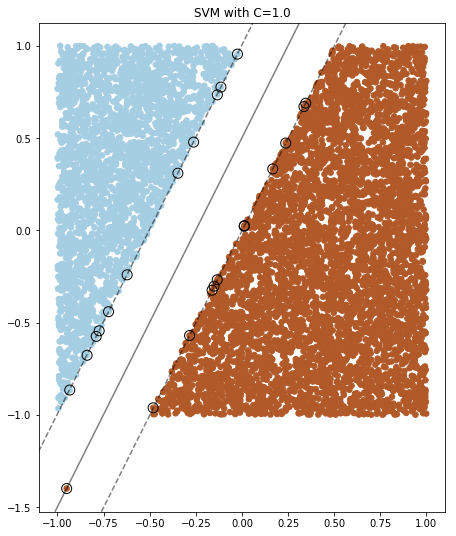

In [39]:
print(f"Scoring of SVC with all defaults: {clf.score(X_test, y_test)}")
plot_svm_margins(X_train, y_train, clf)

### Gridsearch for C values

